## CG power computations


##### Methodology [here] (https://github.com/Eden-Kramer-Lab/spectral_connectivity/blob/master/examples/Intro_tutorial.ipynb)

<br>

### Prepare environment

In [6]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import friedmanchisquare, wilcoxon
from scipy.signal import iirnotch, filtfilt, lfilter
from spectral_connectivity import Multitaper, Connectivity
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
def save_figure(directory, filename_base, dpi=300):
    """
    Save the current figure as both SVG and PNG files in the specified directory.
    Arguments:
    directory - The directory where the files will be saved.
    filename_base - The base name for the files (without extension).
    dpi - The resolution of the PNG file (default is 300).
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Construct file paths
    svg_path = os.path.join(directory, f"{filename_base}.svg")
    png_path = os.path.join(directory, f"{filename_base}.png")
    # Save as SVG
    plt.savefig(svg_path, format='svg', bbox_inches='tight')    
    # Save as PNG
    plt.savefig(png_path, format='png', dpi=dpi, bbox_inches='tight')
    print(f"Figures saved as {svg_path} and {png_path}")

<br>

### Open datasets

In [330]:
main_path = 'PreProcessedData'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)
cg_data.loc[(cg_data['phase']=='Test (Pre-choice)')|(cg_data['phase']=='Test (Past-choice)'), 'phase']='Test'

In [331]:
# Calculate i, a cumulative count of rows per ripple
cg_data['i']=cg_data.groupby(['ripple_nr']).cumcount()
cg_data.groupby(['phase']).ripple_nr.nunique()

phase
Delay     346
ITI       296
Sample    515
Test      421
Name: ripple_nr, dtype: int64

In [337]:
def split_by_phase(df):
    #df = df.drop(columns=['TT6', 'TT4', 'TT8', 'TT10'])
    df = df.drop(columns=['TT1', 'TT2', 'TT4', 'TT5', 'TT6', 'TT8', 'TT10'])
    sample_df = df.loc[df['phase']=='Sample'].drop(['phase'], axis=1)
    delay_df = df.loc[df['phase']=='Delay'].drop(['phase'], axis=1)
    test_df = df.loc[df['phase']=='Test'].drop(['phase'], axis=1)
    iti_df = df.loc[df['phase']=='ITI'].drop(['phase'], axis=1)
    return sample_df, delay_df, test_df, iti_df

In [338]:
# Split dataset into single dataset per phase
sample, delay, test, iti = split_by_phase(cg_data)

In [13]:
#del iti, delay, test, ripple_data, cg_data

In [359]:
# Save number of ripples to be able to map each to respective information later on
np.save(os.path.join(main_path, 'sample_ripple_numbers.npy'), sample.ripple_nr.unique())

In [381]:
# Save tetrodes used (same across phases)
np.save(
    os.path.join(main_path, 'tetrode_numbers.npy'), 
    sample.columns[sample.columns.str.contains('TT')].values
)

<br>

### Create connectivity object

    - Prepare dataframe for Multitaper
    - Perform Multitaper fourrier transform
    - Create the connectivity object

<br>

#### Prepare for multitaper
"If we have three dimensions, dimension 1 is time, dimension 2 is trials, and dimensions 3 is signals. It is important to know note that dimension 2 now has a different meaning in that it represents trials and not signals now. Dimension 3 is now the signals dimension. We will show an example of this later." time_series : array, shape (n_time_samples, n_trials, n_signals).

In [340]:
def prepare_for_multitaper(df):
    '''
    Prepare for multitaper by reshaping dataframe
    df: DataFrame.
    '''
    
    print("Original DataFrame shape:", df.shape)   
    # Drop unnecessary columns
    to_drop = ['start_time', 'end_time', 'timestamp']
    df = df.drop(to_drop, axis=1)
    
    # Check for NaN values in each column
    nan_summary = df.isna().sum()
    print("Missing Data Summary Before Reshaping:\n", nan_summary)
    
    # Create TT list
    tts = [col for col in df.columns if col.startswith('TT')]
     
    # Re-shape dataset into array
    reshaped = df.pivot_table(
        index='i',
        columns='ripple_nr',
        values=tts,
        dropna=False
    ).values
    
    reshaped = reshaped.reshape(
        (
            df['i'].nunique(),
            df['ripple_nr'].nunique(),
            len(tts)
        )
    )
    print("Final reshaped array shape:", reshaped.shape)      
    print("Nans in reshaped:", np.isnan(reshaped).sum())
    reshaped[np.isnan(reshaped)] = np.nanmean(reshaped)
    return reshaped

In [341]:
reshaped_iti = prepare_for_multitaper(iti)
reshaped_sample = prepare_for_multitaper(sample)
reshaped_delay = prepare_for_multitaper(delay)
reshaped_test = prepare_for_multitaper(test)

Original DataFrame shape: (2960294, 14)
Missing Data Summary Before Reshaping:
 ripple_nr             0
TT11                  0
TT12                  0
TT13                  0
TT14                  0
TT3                   0
TT7                   0
TT9                   0
session_code          0
relative_timestamp    0
i                     0
dtype: int64
Final reshaped array shape: (10001, 296, 7)
Nans in reshaped: 14
Original DataFrame shape: (5150511, 14)
Missing Data Summary Before Reshaping:
 ripple_nr             0
TT11                  0
TT12                  0
TT13                  0
TT14                  0
TT3                   0
TT7                   0
TT9                   0
session_code          0
relative_timestamp    0
i                     0
dtype: int64
Final reshaped array shape: (10001, 515, 7)
Nans in reshaped: 28
Original DataFrame shape: (3460342, 14)
Missing Data Summary Before Reshaping:
 ripple_nr             0
TT11                  0
TT12                  0
TT13

<br>


#### Apply a notch filter 

Before the Fourrier transform to remove 50Hz electrical noise. 

In [342]:
def apply_notch_filter_3d(data, notch_freq, fs, quality_factor):
    """
    Apply a notch filter to a 3D numpy array with time series data.
    Parameters:
    - data: 3D numpy array with shape (number_of_samples, trials, tetrodes)
    - notch_freq: Frequency to notch out (in Hz)
    - fs: Sampling frequency (in Hz)
    - quality_factor: Quality factor of the notch filter
    Returns:
    - filtered_data: 3D numpy array with the notch filter applied
    """
    # Ensure the input data is a numpy array
    data = np.array(data)
    
    # Check for NaNs in the input data
    if np.any(np.isnan(data)):
        raise ValueError("Input data contains NaNs. Please clean data before filtering.")    
    # Design the notch filter
    nyquist = 0.5 * fs
    normal_cutoff = notch_freq / nyquist
    b, a = iirnotch(normal_cutoff, quality_factor)   
    # Initialize the filtered_data array
    filtered_data = np.empty_like(data)    
    # Iterate over each time sample
    for j in range(data.shape[1]):  # Iterate over trials
        for k in range(data.shape[2]):  # Iterate over tetrodes
                
            # Extract the 1D array for filtering
            signal = data[:, j, k]              
            # Apply the notch filter if signal is valid
            if np.size(signal) > 1:       
                filtered_data[:, j, k] = lfilter(b, a, signal)

    return filtered_data

In [343]:
filtered_iti = apply_notch_filter_3d(reshaped_iti, 50, 5000, quality_factor=50.0)
filtered_sample = apply_notch_filter_3d(reshaped_sample, 50, 5000, quality_factor=50.0)
filtered_delay = apply_notch_filter_3d(reshaped_delay, 50, 5000, quality_factor=50.0)
filtered_test = apply_notch_filter_3d(reshaped_test, 50, 5000, quality_factor=50.0)

In [18]:
#del reshaped_sample

<br>

####  Create multitaper object

Controls the duration of the segment of time the transformation is computed on (seconds)
w_duration = 0.1
Control how far the time window is slid (overlap).
Setting the step to smaller than the time window duration will make the time windows overlap
step = 0.02
Controls the frequency resolution of the Fourier transformed signal.
Setting this parameter will define the default number of tapers used in the transform 
(number of tapers = 2 * time_halfbandwidth_product - 1.).
Need to study this one although setting the above automatically changes this one
time_halfbandwidth_product = 10

#### Create connectivity object
The Connectivity class computes the frequency-domain connectivity measures from the Fourier coeffcients.

In [19]:
def get_conn (df, fs, step, window, exp_type, nblocks, time_halfbandwidth_product):
    
    '''
    Prepares dataframe provided for multitaper
    Creates a multitaper object
    Inputs the multitaper object to create a connectivity object.
    '''
    
    multitaper = Multitaper(
        df, 
        sampling_frequency=fs, 
        n_time_samples_per_window=window,
        n_time_samples_per_step = step,
        time_halfbandwidth_product = time_halfbandwidth_product
    )
    
    print(multitaper)            
    conn = Connectivity.from_multitaper(
        multitaper, 
        expectation_type = exp_type, 
        blocks = nblocks 
    )
    
    return conn   

In [20]:
fs = 5000
window =1667 #5000 # N samples in sliding window in which to compute the fft 
#(5K=1s, 1667 = 333.33 ms for frequency bins of 3Hz)  
step = 500 #500 # N samples in step to skip when moving the window forward (500 =  100 ms)
nblocks = 2000 # Number of blocks to split up input arrays to do block computation
exp_type = "tapers" #'tapers' only averages over tapers (leaving trials).  
time_halfbandwidth_product= 3 #Product of time and bandwith. Defines n_Tapers too.

In [21]:
iti_conn = get_conn(
    filtered_iti, fs=fs, step=step, window=window,
    time_halfbandwidth_product= time_halfbandwidth_product, exp_type=exp_type, nblocks=nblocks
)

In [22]:
delay_conn = get_conn(
    filtered_delay,fs= fs, window=window, step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product, exp_type=exp_type, nblocks=nblocks
)

In [23]:
sample_conn = get_conn(
    filtered_sample, fs= fs, window=window, step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,exp_type=exp_type,nblocks=nblocks
)

Multitaper(sampling_frequency=5000, time_halfbandwidth_product=3,
           time_window_duration=0.3334, time_window_step=0.1,
           detrend_type='constant', start_time=0, n_tapers=5)


In [24]:
test_conn = get_conn(
    filtered_test, fs= fs, window=window, step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product, exp_type=exp_type, nblocks=nblocks
)

In [25]:
#del filtered_sample

<br>


### Get power metrics for time and frequency bins across trials and tetrodes


    - Get time bins, frequency bins and respective power measures for each (across trials and tetrodes)
    - Save raw data.

In [27]:
def get_metrics(conn):
    
    """
    Calculate the average power and standard deviation across tetrodes and trials.  
    Parameters:
    conn : connectivity object
        An object containing LFP data, with methods to access power, time, and frequency information.  
    Returns:
        freqs (np.ndarray): Array of frequency values.
        times (np.ndarray): Array of time labels.
        power (np.ndarray): Original power array with dimensions (Time windows, trials, Frequencies, Tetrodes).
    """

    # Retrieve time labels and frequencies from the connectivity object
    times = conn.time
    freqs = conn.frequencies  
    # Calculate power with dimensions (Time windows, trials, Frequencies, Tetrodes)
    power = conn.power()     
    return freqs, times, power

In [28]:
iti_freqs, iti_times, iti_power = get_metrics(iti_conn)
iti_freqs.shape, iti_times.shape, iti_power.shape

In [ ]:
sample_freqs, sample_times, sample_power = get_metrics(sample_conn)
sample_freqs.shape, sample_times.shape, sample_power.shape

In [329]:
delay_freqs, delay_times, delay_power = get_metrics(delay_conn)
delay_freqs.shape, delay_times.shape, delay_power.shape

NameError: name 'delay_conn' is not defined

In [ ]:
test_freqs, test_times, test_power = get_metrics(test_conn)
test_freqs.shape, test_times.shape, test_power.shape

<br>

### 3. Save data

In [30]:
def save_arrays(array1, array2, array3, save_dir, filename1, filename2, filename3):
    """
    Save three arrays to disk in a specified directory, where the first two are 2D arrays and the third is a 4D array.
    Parameters:
    - array1: First 2D numpy array
    - array2: Second 2D numpy array
    - array3: Third 4D numpy array
    - save_dir: Directory path where arrays will be saved
    - filename1: Filename for saving the first 2D array 
    - filename2: Filename for saving the second 2D array
    - filename3: Filename for saving the third 4D array
    """

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)  
    # Save arrays to .npy files
    np.save(os.path.join(save_dir, filename1), array1)
    np.save(os.path.join(save_dir, filename2), array2)
    np.save(os.path.join(save_dir, filename3), array3)

In [31]:
# Save arrays to a .npz file
save_arrays(iti_times, iti_freqs, iti_power, main_path, 
           filename1='iti_times.npy', filename2='iti_freqs.npy', filename3='iti_power.npy')

save_arrays(sample_times, sample_freqs, sample_power, main_path, 
           filename1='sample_times.npy', filename2='sample_freqs.npy', filename3='sample_power.npy')

save_arrays(delay_times, delay_freqs, delay_power, main_path, 
           filename1='delay_times.npy', filename2='delay_freqs.npy', filename3='delay_power.npy')

save_arrays(test_times, test_freqs, test_power, main_path, 
           filename1='test_times.npy', filename2='test_freqs.npy', filename3='test_power.npy')

In [144]:
#save_arrays(iti_times, iti_freqs, iti_power, main_path, 
#          filename1='iti_lat_times.npy', filename2='iti_lat_freqs.npy', filename3='iti_lat_power.npy')

#save_arrays(delay_times, delay_freqs, delay_power, main_path, 
#           filename1='delay_lat_times.npy', filename2='delay_lat_freqs.npy', filename3='delay_lat_power.npy')
#save_arrays(test_times, test_freqs, test_power, main_path, 
#           filename1='test_lat_times.npy', filename2='test_lat_freqs.npy', filename3='test_lat_power.npy')

<br>

# Spectral analysis of CG activity

1. z-scored linear averaged power variations across bands of interest (<100Hz) and timepoints of interest
2. Same analysis in terms of relative power variations.



##### Load arrays

In [34]:
def load_arrays(path, filename1, filename2, filename3):
    """
    Load three arrays from disk in a specified directory, where the first two are 2D arrays and the third is a 4D array.
    Parameters:
    - path: Directory path where arrays are saved
    - filename1: Filename for the first 2D array
    - filename2: Filename for the second 2D array
    - filename3: Filename for the third 4D array
    Returns:
    - array1: Loaded 2D numpy array from filename1
    - array2: Loaded 2D numpy array from filename2
    - array3: Loaded 4D numpy array from filename3
    """

    # Load arrays from .npy files
    array1 = np.load(os.path.join(path, filename1))
    array2 = np.load(os.path.join(path, filename2))
    array3 = np.load(os.path.join(path, filename3))
    return array1, array2, array3

In [35]:
#iti_times, iti_freqs, iti_power = load_arrays(main_path, 'iti_times.npy', 'iti_freqs.npy', 'iti_power.npy')
sample_times, sample_freqs, sample_power = load_arrays(main_path, 'sample_times.npy', 'sample_freqs.npy', 'sample_power.npy')
#delay_times, delay_freqs, delay_power = load_arrays(main_path, 'delay_times.npy', 'delay_freqs.npy', 'delay_power.npy')
#test_times, test_freqs, test_power = load_arrays(main_path, 'test_times.npy', 'test_freqs.npy', 'test_power.npy')

In [145]:
#iti_times, iti_freqs, iti_power = load_arrays(main_path, 'iti_lat_times.npy', 'iti_lat_freqs.npy', 'iti_lat_power.npy')
#delay_times, delay_freqs, delay_power = load_arrays(main_path, 'delay_lat_times.npy', 'delay_lat_freqs.npy', 'delay_lat_power.npy')
#test_times, test_freqs, test_power = load_arrays(main_path, 'test_lat_times.npy', 'test_lat_freqs.npy', 'test_lat_power.npy')

<br>

## 1. Analysis on z-scored absolute power
    - Calculate z-scored averaged power for both outlier removed and non-outlier removed datasets
    - Plot the PSD for each dataset 
    - Compare bands of interest

### 1.1 Z-score data (for each trace) and/or remove outliers

<br>

#### Z-score linear power 

In [36]:
def zscore_4d_power(data):
    """
    Z-score the power values in a 4D array by each sample.
    Parameters:
    - data: 4D numpy array of shape (time_bins, trials, freq_bins, samples/tetrodes)
    Returns:
    - 4D numpy array with z-scored power values, maintaining the same shape as the input data
    """
    # Calculate mean and std withn trial and tetrode (across time_bins and freq_bins)
    mean = np.mean(data, axis=(0, 2), keepdims=True)
    std = np.std(data, axis=(0, 2), keepdims=True)   
    return (data - mean) / std  

In [37]:
#iti_power_zscored = zscore_4d_power(iti_power)
#iti_power_zscored.shape, iti_power_zscored.min(), iti_power_zscored.max()
sample_power_zscored = zscore_4d_power(sample_power)
#delay_power_zscored = zscore_4d_power(delay_power)
#test_power_zscored = zscore_4d_power(test_power)

<br>

#### Remove outliers

In [231]:
def remove_outliers_zscored(data, z_threshold):
    """
    Detect and remove outliers from a z-scored 4D array by substituting outliers with the average
    within their respective trial and tetrode. Provides a comparative visualization of the power 
    distributions before and after outlier removal.
    Parameters:
    - data: 4D numpy array of z-scored power values with shape (time, trials, frequencies, tetrodes)
    - z_threshold: The z-score threshold for detecting outliers
    Returns:
    - cleaned_data: 4D numpy array with outliers removed, maintaining the same shape
    - percentage_removed: Percentage of data points removed as outliers
    """
    
    # Copy data to avoid modifying the original
    data_cleaned = np.copy(data)   
    # Calculate the percentage of outliers and replace them within their respective trial and tetrode
    total_elements = np.prod(data.shape)
    outliers_count = 0

    for trial in range(data.shape[1]):
        for tetrode in range(data.shape[3]):
            # Isolate the data slice for the current trial and tetrode
            slice_data = data[:, trial, :, tetrode]

            # Identify outliers in this slice
            outliers = np.abs(slice_data) > z_threshold

            # Count the outliers
            outliers_count += np.sum(outliers)

            # Compute the mean of the non-outlier values in this slice
            slice_mean = np.nanmean(slice_data[~outliers])

            # Replace outliers with the slice mean
            slice_data[outliers] = slice_mean

            # Assign the cleaned slice back to the cleaned_data array
            data_cleaned[:, trial, :, tetrode] = slice_data

    # Calculate the percentage of data points removed as outliers
    percentage_removed = (outliers_count / total_elements) * 100
    print(f"Percentage of data points replaced as outliers: {percentage_removed:.2f}%")
    # Comparative visualization of power distributions
    
    plt.figure(figsize=(12, 6))  
    # Before removal
    plt.subplot(1, 2, 1)
    sns.histplot(data.flatten(), bins=50, kde=True, color='blue')
    plt.title('Power Distribution Before Outlier Removal')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')
    # After removal
    plt.subplot(1, 2, 2)
    sns.histplot(data_cleaned.flatten(), bins=50, kde=True, color='green')
    plt.title('Power Distribution After Outlier Removal')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')  
    plt.tight_layout()
    plt.show()

    return data_cleaned


In [232]:
#iti_power_processed = remove_outliers_zscored(iti_power_zscored.copy(), z_threshold=2.5)
#iti_power_processed.shape, iti_power_processed.min(),iti_power_processed.max(), iti_power_zscored.mean()

Percentage of data points replaced as outliers: 0.79%


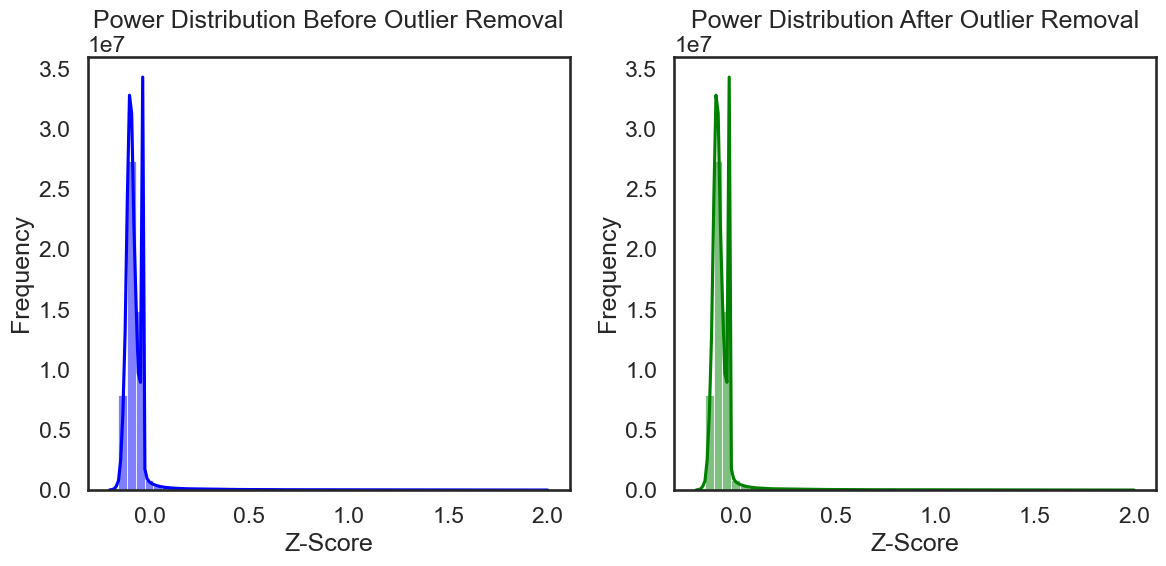

(17, 514, 864, 7)

In [233]:
sample_power_processed = remove_outliers_zscored(sample_power_zscored.copy(), z_threshold=2)
# Trial 285 had power changes that were affecting the reading of results as outliers. 
sample_power_processed = np.delete(sample_power_processed, 285, axis=1)
sample_power_processed.shape

In [247]:
sample_power_processed = np.delete(sample_power_processed, 284, axis=1)
sample_power_processed.shape

(17, 513, 864, 7)

In [147]:
#delay_power_processed = remove_outliers_zscored(delay_power_zscored.copy(), z_threshold=2.5)

In [40]:
#test_power_processed = remove_outliers_zscored(test_power_zscored.copy(), z_threshold=2.5)

<br>
<br>

### 1.2 Plot average PSD

##### Calcaulte average power across tetrodes and trials

In [248]:
def average_power(data):
    """
    Calculate the average power and standard deviation.
    Parameters:
    - data: 4D numpy array with shape (time_bins, trials, freq_bins, samples)
    Returns:
    - avg_power: 2D numpy array of shape (time_bins, freq_bins) with average power
    - std_power: 2D numpy array of shape (time_bins, freq_bins) with standard deviation of power
    """
    # Calculate average power across tetrodes (axis3) and trials (axis1)
    avg_power = np.mean(data, axis=(3, 1)) 
    # Calculate standard deviation of power across tetrodes (axis3) and trials (axis1)
    std_power = np.std(data, axis=(3,1)) 
    # Calculate median power
    median_power = np.median(data, axis=(3,1))
    return avg_power, std_power, median_power

In [249]:
#iti_mean_ppower, iti_std_ppower, iti_median_ppower = average_power(iti_power_processed)  
sample_mean_ppower, sample_std_ppower, sample_median_ppower = average_power(sample_power_processed)  
#delay_mean_ppower, delay_std_ppower, delay_median_ppower = average_power(delay_power_processed)  
#test_mean_ppower, test_std_ppower,test_median_ppower = average_power(test_power_processed)  

<br>

## Plot average PSD 
Plots PSD for each phase. Consider that power data was collected between -0.5 and 1 secs in relation to SWR onset.
However we are only interested in showing between -0.5 sec and 0.5 sec. 

In [49]:
def plot_psd_band(time_bins, frequency_bins, power, x_tick_labels=None, ylim=None, vmin=None, vmax=None):
    """
    Create a Power Spectral Density (PSD) plot using imshow with Gaussian interpolation.

    Parameters:
    - time_bins: 1D numpy array of time bins
    - frequency_bins: 1D numpy array of frequency bins
    - power: 2D numpy array of power values with shape (time_bins, frequency_bins)
    - x_tick_labels: List or array of custom labels for the x-axis (time bins)
    - ylim: Tuple specifying the y-axis limits (min, max) in frequency_bins or None to auto-scale
    - vmin: Minimum value for the color scale or None to auto-scale based on filtered data
    - vmax: Maximum value for the color scale or None to auto-scale based on filtered data
    """
    # Ensure inputs are correctly shaped
    if power.shape[0] != len(time_bins) or power.shape[1] != len(frequency_bins):
        raise ValueError("Shape of power array must match the length of time_bins and frequency_bins.")

    # Filter time_bins and corresponding power values to only include those between 0 and 1
    valid_indices = np.where((time_bins >= 0) & (time_bins <= 1))[0]
    filtered_time_bins = time_bins[valid_indices]
    filtered_power = power[valid_indices]

    # Filter the power and frequency_bins based on ylim
    ylim_indices = [np.searchsorted(frequency_bins, val) for val in ylim]
    filtered_frequency_bins = frequency_bins[ylim_indices[0]:ylim_indices[1]]
    filtered_power = filtered_power[:, ylim_indices[0]:ylim_indices[1]]

    # Recalculate vmin and vmax based on the filtered power data if not provided
    if vmin is None:
        vmin = np.min(filtered_power)
    if vmax is None:
        vmax = np.max(filtered_power)

    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4), dpi=300)

    # Plot using imshow
    plt.imshow(
        filtered_power.T,  # Transpose to match the orientation (time on x-axis, frequency on y-axis)
        aspect='auto',  # Automatic aspect ratio
        cmap='jet',  # Color map
        origin='lower',  # Set origin to lower-left
        interpolation='gaussian',  # Use Gaussian interpolation
        vmin=vmin,  # Set the minimum value for the color scale
        vmax=vmax   # Set the maximum value for the color scale
    )

    # Add colorbar and labels
    plt.colorbar(label='Power')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')

    # Set y-ticks at every 5th tick, starting from 0 (for the filtered frequency bins)
    y_ticks = np.arange(0, len(filtered_frequency_bins), 5)   
    y_labels = (np.round(filtered_frequency_bins[::5], 2)).astype(int)  # Label every 5th frequency
    plt.yticks(ticks=y_ticks, labels=y_labels)

    # Set x-ticks using the provided x_tick_labels if available, rounded to one decimal place
    if x_tick_labels is not None:
        rounded_labels = [round(label, 2) for label in x_tick_labels]  # Round to one decimal place
        plt.xticks(ticks=np.arange(len(rounded_labels)), labels=rounded_labels)

    # Add vertical white dotted line where time_bin == 0.5
    if 0.5 in filtered_time_bins:
        time_bin_index = np.searchsorted(filtered_time_bins, 0.5)  # Find index where time_bin == 0.5
        plt.axvline(x=time_bin_index, color='white', linestyle='--', linewidth=2)

    # Add title and show the plot
    plt.title('Power Spectral Density (PSD)')
    plt.grid(False)
    sns.despine()
    #plt.show()

    print('Filtered Frequency bins: {}'.format(filtered_frequency_bins))
    print('Time bins: {}'.format(filtered_time_bins))
    print(vmin, vmax)

In [50]:
x_tick_labels = sample_times[0:11]-0.5

#### ITI :

In [251]:
#iti_mean_ppower.min(), iti_mean_ppower.max()
#plot_psd_band(
#    iti_times, iti_freqs, iti_mean_ppower, ylim=(0,63), x_tick_labels=x_tick_labels)#, vmin=0, vmax=0.9)
#plt.axhline(y=7, color='lightgray', linestyle=':', linewidth=1)
#plt.axhline(y=10, color='lightgray', linestyle=':', linewidth=1)
#plt.show()

In [252]:
#plot_psd_band(
#    iti_times, iti_freqs, iti_median_ppower, ylim=(0,63), x_tick_labels=x_tick_labels)#, vmin=0,  vmax=.9)

### SAMPLE

-0.08997499456107014 0.7630348434378512
Filtered Frequency bins: [ 0.          2.89351852  5.78703704  8.68055556 11.57407407 14.46759259
 17.36111111 20.25462963 23.14814815 26.04166667 28.93518519 31.8287037
 34.72222222 37.61574074 40.50925926 43.40277778 46.2962963  49.18981481
 52.08333333 54.97685185 57.87037037 60.76388889]
Time bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0 0.9


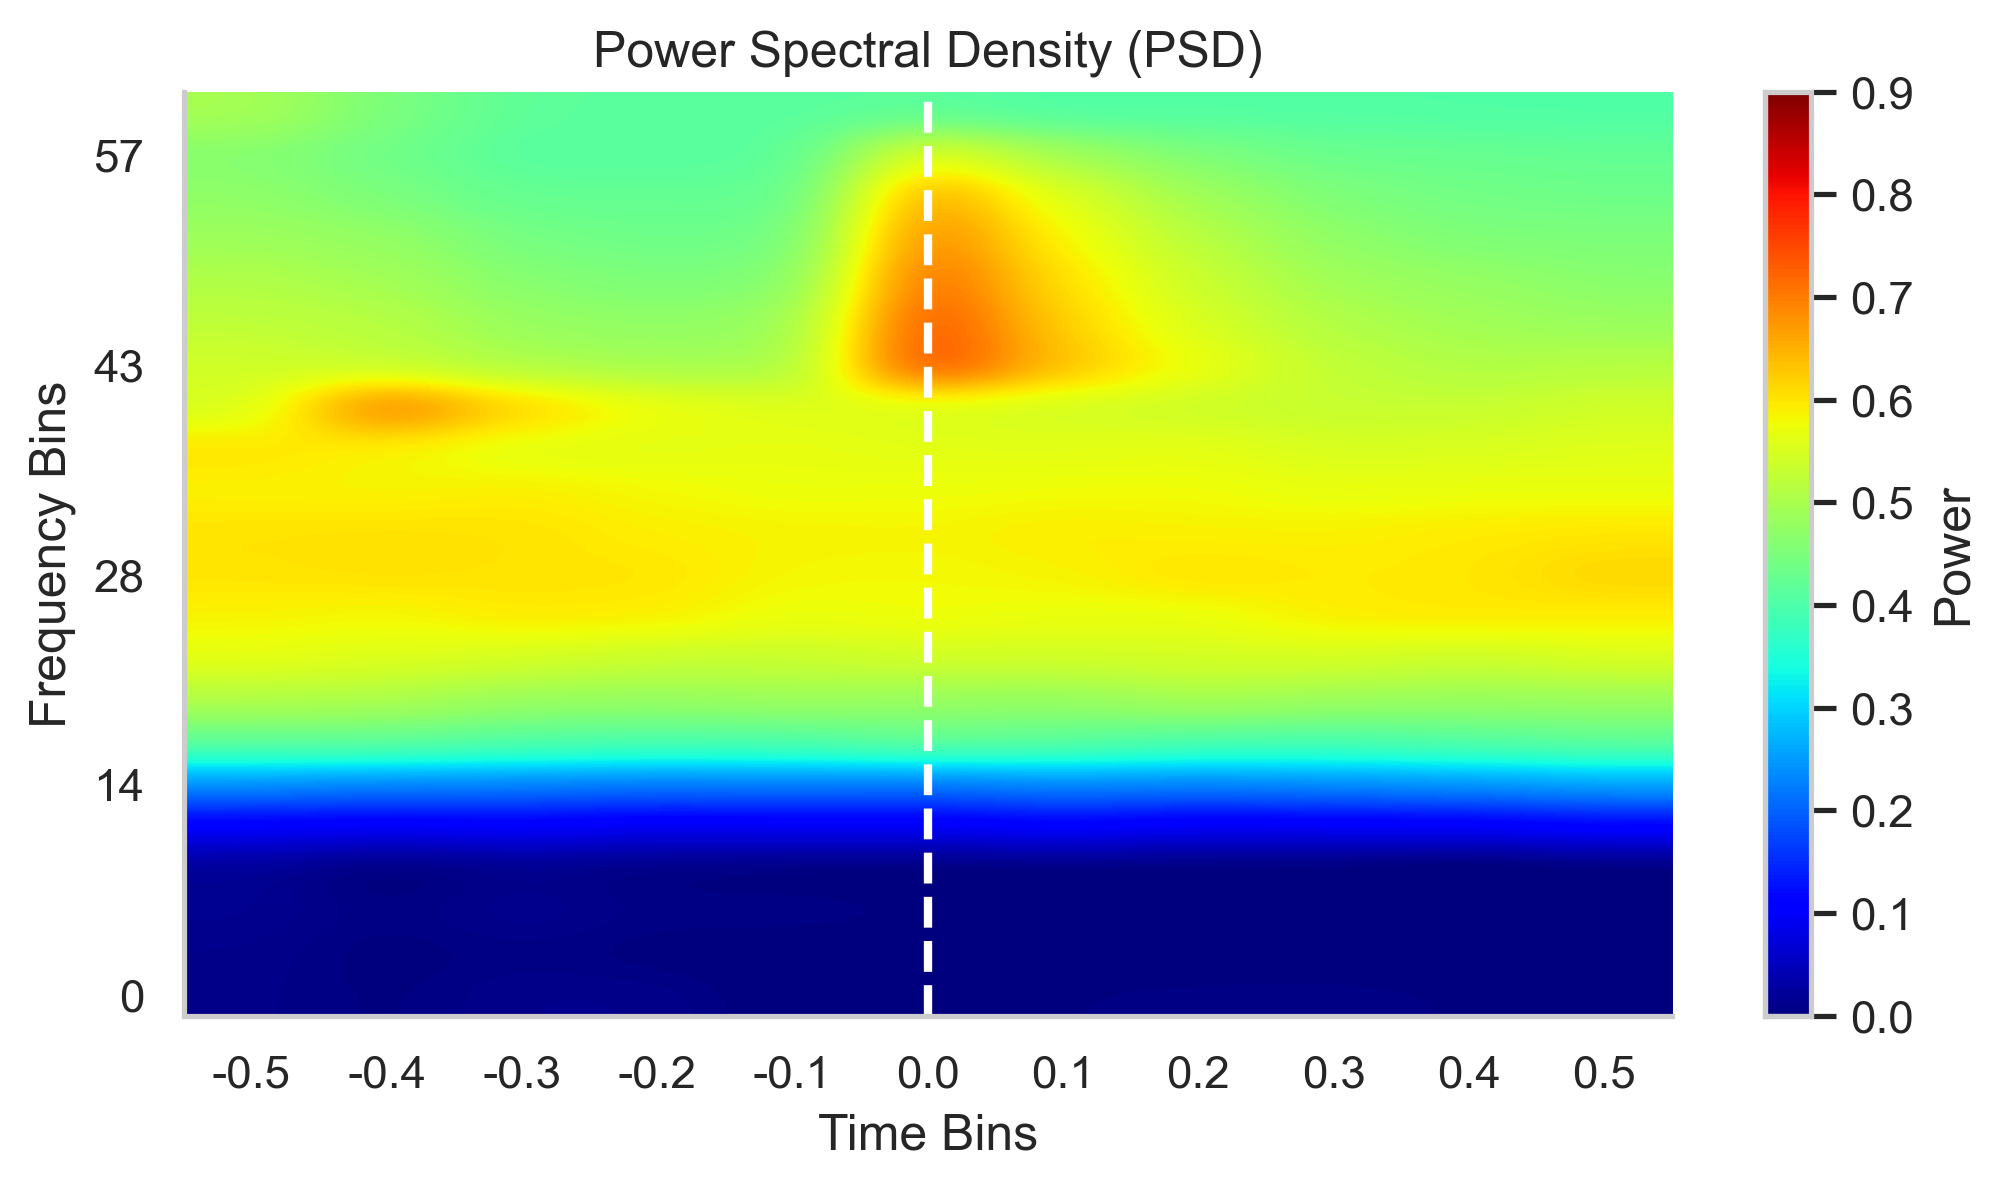

In [253]:
print(sample_mean_ppower.min(), sample_mean_ppower.max())
plot_psd_band(
    sample_times, sample_freqs, sample_mean_ppower, 
    ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.9)
#plt.axhline(y=13, color='lightgray', linestyle=':', linewidth=1)
#plt.axhline(y=16, color='lightgray', linestyle=':', linewidth=1)


-0.09594845191747384 0.6636052365579114
Filtered Frequency bins: [ 0.          2.89351852  5.78703704  8.68055556 11.57407407 14.46759259
 17.36111111 20.25462963 23.14814815 26.04166667 28.93518519 31.8287037
 34.72222222 37.61574074 40.50925926 43.40277778 46.2962963  49.18981481
 52.08333333 54.97685185 57.87037037 60.76388889]
Time bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0 0.9


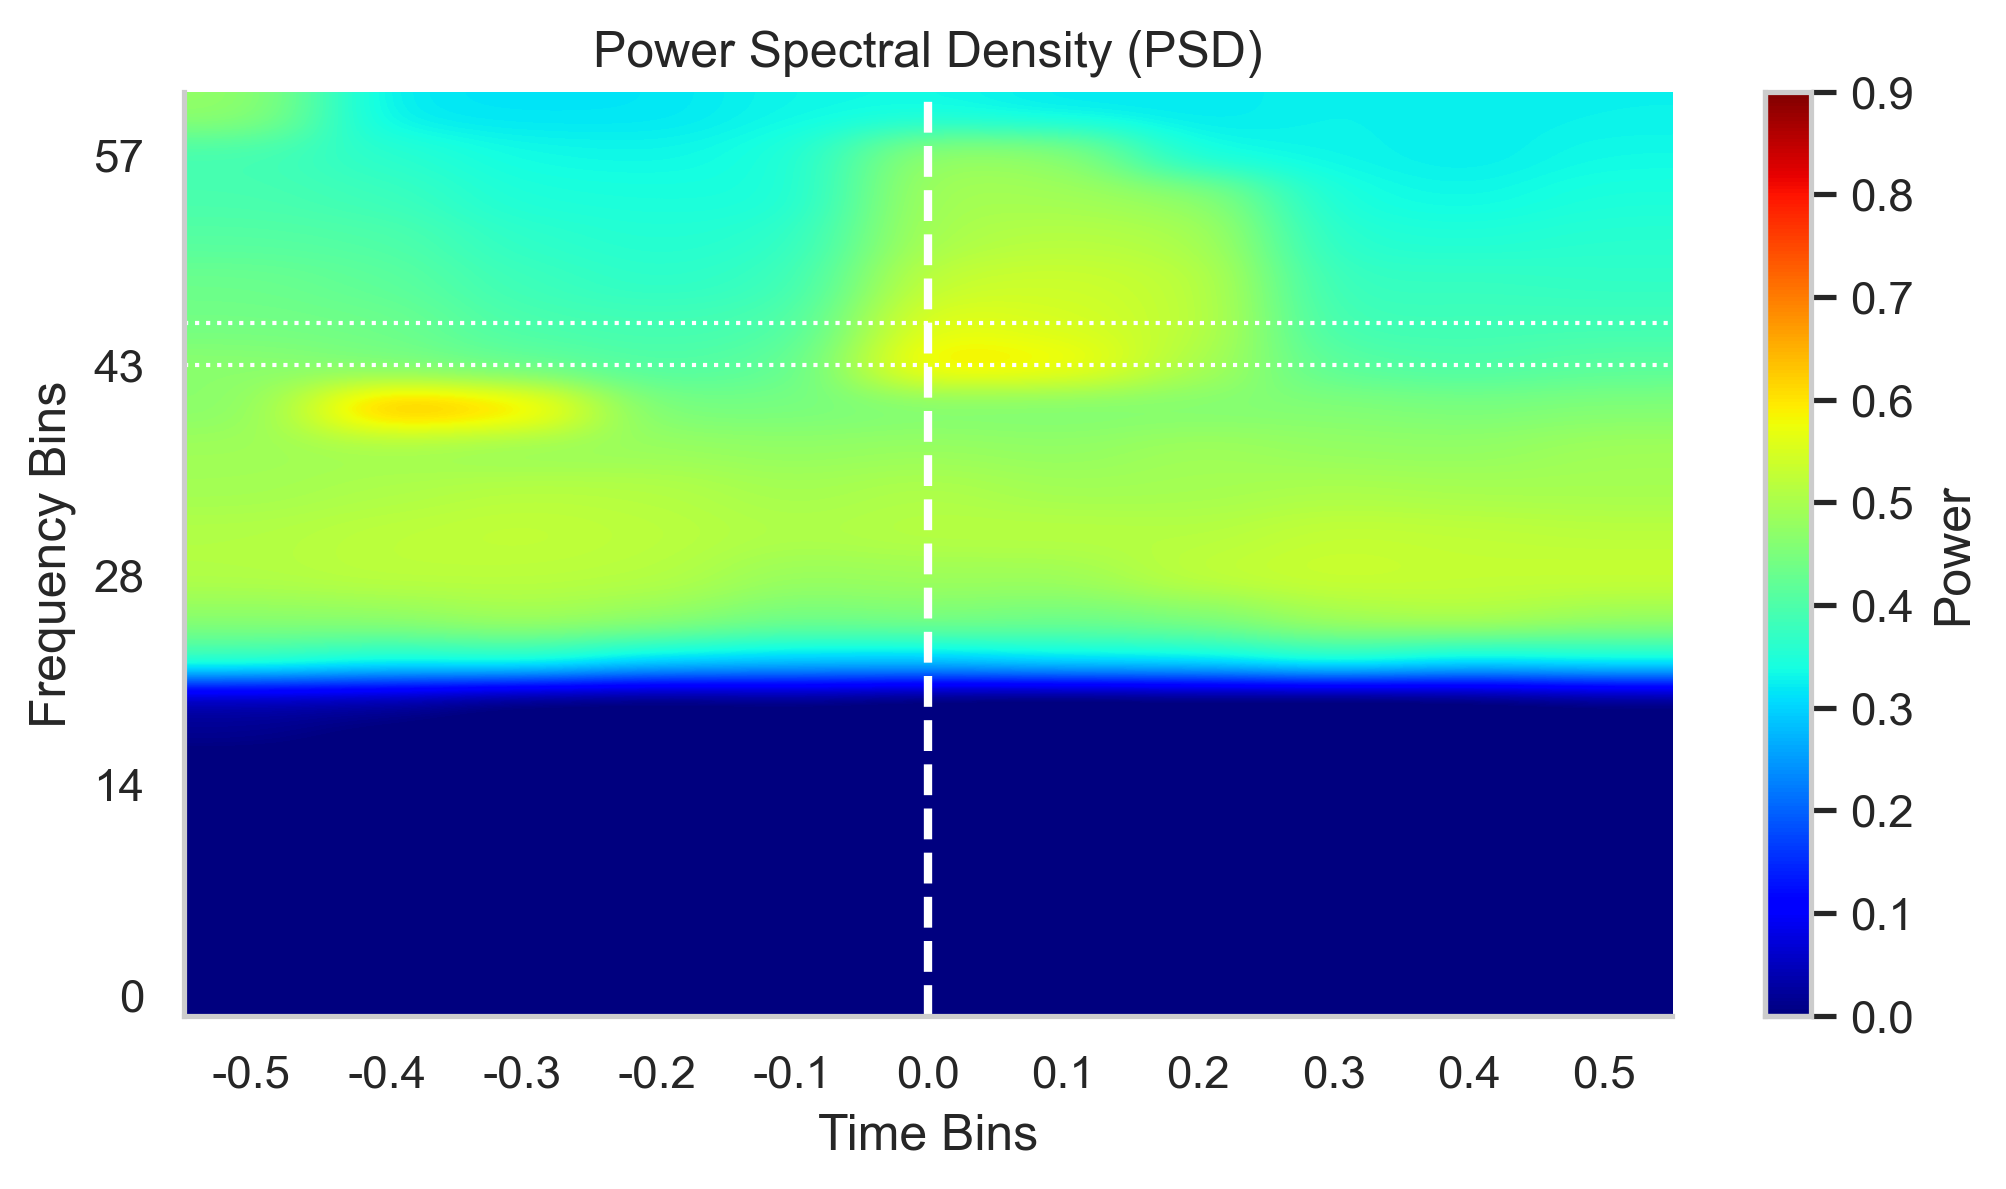

In [254]:
print(sample_median_ppower.min(), sample_median_ppower.max())
plot_psd_band(
   sample_times, sample_freqs, sample_median_ppower, 
    ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.9)
plt.axhline(y=15, color='white', linestyle=':', linewidth=1)
plt.axhline(y=16, color='white', linestyle=':', linewidth=1)
plt.show()

### DELAY



In [255]:
#delay_mean_ppower.min(), delay_mean_ppower.max()
#plot_psd_band(
#    delay_times, delay_freqs, delay_mean_ppower, ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.8)
#plt.axhline(y=7, color='white', linestyle=':', linewidth=1)
#plt.axhline(y=10, color='white', linestyle=':', linewidth=1)
#plt.show()

In [244]:
##delay_median_ppower.min(), delay_median_ppower.max()
#plot_psd_band(
#    delay_times, delay_freqs, delay_median_ppower, ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.75)
#plt.axhline(y=7, color='white', linestyle=':', linewidth=1)
#plt.axhline(y=11, color='white', linestyle=':', linewidth=1)
#plt.show()

#### TEST

In [245]:
#print(test_mean_ppower.min(), test_mean_ppower.max())
#plot_psd_band(test_times, test_freqs, test_mean_ppower, ylim=(23,30), x_tick_labels=x_tick_labels)#, vmin=0, vmax=0.95)
#plt.axhline(y=7, color='white', linestyle=':', linewidth=1)
#plt.axhline(y=12, color='white', linestyle=':', linewidth=1)
#plt.show()

In [246]:
#plot_psd_band(test_times, test_freqs, test_median_ppower, ylim=(23,30), x_tick_labels=x_tick_labels)#, vmin=0, vmax=0.9)
#plt.axhline(y=8, color='white', linestyle=':', linewidth=1)
#plt.axhline(y=10, color='white', linestyle=':', linewidth=1)
#plt.show()

<br>
<br>

### 1.3 Plot z-scored power distributions across time

For this section, we plotted the power distributions over time for 2Hz sized frequency slots.
We visually compared the average and median trends over time but also the trend of individual traces. 
Further exploration was only conducted if an interestering trend was found (point 1.4 onwards)

##### Convert array to a long-format dataframe (to plot)

In [220]:
def convert_to_long_format(
    data_array, time_bin_values, frequency_bin_values,
    time_bin_label='time_bins', trial_label='trials', freq_bin_label='frequency_bins', 
    tetrode_label='tetrode', power_label='power'
    ):
    """
    Convert a 4D array (time_bins, trials, frequency_bins, tetrodes) into a long-format pandas DataFrame.   
    Parameters:
    - data_array: 4D numpy array with shape (time_bins, trials, frequency_bins, tetrodes)
    - time_bin_values: 1D numpy array or list of time bin labels
    - frequency_bin_values: 1D numpy array or list of frequency bin labels
    - time_bin_label: Column name for time bins (default: 'time_bins')
    - trial_label: Column name for trials (default: 'trials')
    - freq_bin_label: Column name for frequency bins (default: 'frequency_bins')
    - tetrode_label: Column name for tetrodes (default: 'tetrode')
    - power_label: Column name for power values (default: 'power')
    Returns:
    - long_format_df: A pandas DataFrame in long format with columns [time_bins, trials, frequency_bins, tetrode, power]
    """
    # Get the shape of the input array
    time_bins = data_array.shape[0]
    trials = data_array.shape[1]
    frequency_bins = data_array.shape[2]
    tetrodes = data_array.shape[3]
    
    # Check that time_bin_values and frequency_bin_values match the shape of data_array
    if len(time_bin_values) != time_bins:
        raise ValueError(f"Length of time_bin_values ({len(time_bin_values)}) does not match number of time bins ({time_bins})")
    if len(frequency_bin_values) != frequency_bins:
        raise ValueError(f"Length of frequency_bin_values ({len(frequency_bin_values)}) does not match number of frequency bins ({frequency_bins})")
    
    # Reshape the 4D array into a 1D array (flatten the array)
    reshaped_power = data_array.reshape(time_bins * trials * frequency_bins * tetrodes)
    
    # Create multi-index for each combination of time_bins, trials, frequency_bins, and tetrodes
    multi_index = pd.MultiIndex.from_product(
        [time_bin_values, np.arange(trials), frequency_bin_values, np.arange(tetrodes)],
        names=[time_bin_label, trial_label, freq_bin_label, tetrode_label]
    )
    
    # Create the dataframe with 'power' values and the multi-index
    long_format_df = pd.DataFrame({power_label: reshaped_power}, index=multi_index).reset_index() 
   
    return long_format_df

In [221]:
# iti_times -1 to change from absolute to relative timestamps
#iti_ppower_df = convert_to_long_format(
#    iti_power_processed, time_bin_values=iti_times-.5, frequency_bin_values=iti_freqs
#)
sample_ppower_df = convert_to_long_format(
     sample_power_processed, time_bin_values=sample_times-.5, frequency_bin_values=sample_freqs
)
#delay_ppower_df = convert_to_long_format(
#      delay_power_processed, time_bin_values=delay_times-.5, frequency_bin_values=delay_freqs
#)
#test_ppower_df = convert_to_long_format(
#      test_power_processed, time_bin_values=test_times-.5, frequency_bin_values=test_freqs
#)

<br>

##### Plot average z-score power for bands of interest across time bins (and raw data overlay)

In [103]:
def plot_power_with_average(df, band=(4,12), title=None, color='black', ylim=None, xlim=None):
    
    """
    Plot the power values with individual samples and the average overlay.

    Parameters:
    - df: DataFrame in long format with columns [time_bins, frequency_bins, power, ...]
    - band: Tuple to set the band to filter by
    - title: Title of the plot (default is band name)
    - color: Color of the average line (default is black)
    - ylim: Tuple to set the y-axis limits (e.g., (lower, upper))
    - xlim: Tuple to set the x-axis limits (e.g., (lower, upper))
    """
    # Set up the figure and axes
    plt.figure(figsize=(10, 6), dpi=300)
    sns.set(context='talk', style='white')

    df_filtered = df[df.frequency_bins.between(band[0], band[1])]
    df_trials = df_filtered.groupby(['time_bins', 'trials'])['power'].mean().reset_index()

    # Plot the average line
    sns.lineplot(
        data=df_filtered, 
        x='time_bins', 
        y='power',   
        color=color,     
        legend=False,
        errorbar=None,
        estimator=np.mean
    )
    
    # Plot the median line
    sns.lineplot(
        data=df_filtered, 
        x='time_bins', 
        y='power',  
        linewidth=2,  
        color=color,     
        legend=False,
        errorbar=None,
        estimator=np.median,
        linestyle='dotted'
    )
    # Add a vertical dashed line at time_bins == 0
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

    # Set x and y limits if provided
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)

    # Add labels and title
    plt.xlabel('Time Bins')
    plt.ylabel('Power (z-score)')
    
    # Set title (either provided or default to band)
    plt.title(title if title else '')

    # Show the plot
    plt.legend(frameon=False)
    sns.despine()
    plt.grid(False)
    plt.show()


## ITI

In [243]:
#plot_power_with_average(
#    iti_ppower_df, band=(20,28),title='', color=phase_palette[0], ylim=(0.5, 1), xlim=(-0.5,0.5)
#)

### SAMPLE

In [240]:
#plot_power_with_average(
#    sample_ppower_df, band=(43,47),title='', color=phase_palette[1], ylim=(0.2, 1), xlim=(-0.5,0.5))

### DELAY

In [241]:
#plot_power_with_average(
#    delay_ppower_df, band=(23,30),title='', color=phase_palette[2], ylim=(0.4, 0.9), xlim=(-0.5,0.5)
#)

### TEST

In [242]:
#plot_power_with_average(
#    test_ppower_df, band=(23,30),title='', color=phase_palette[3], ylim=(0.6, 1), xlim=(-0.5,0.5)
#)

<br>
<br>

### 1.4 Plot z-scored power distributions changes in points of interest. Perform statistical inference

- Select points of interest (should match amplitude plots)
- Create violin plots for distributions
- Perform statistical testing to determine if there is a time bin effect on power
- Perform pairwise post-hoc comparisons


Times of interest: Dependent on findings

In [224]:
def label_timepoints(df):
    '''
    Adds a timepoint colum to df that labels timepoints of interest
    '''

    df.loc[np.round(df.time_bins, 1) == -0.1, 'timepoint']= '1' 
    df.loc[np.round(df.time_bins,1) == 0, 'timepoint']= '2' 
    df.loc[np.round(df.time_bins,1) == 0.1, 'timepoint']= '3'
    
    return df

In [225]:
def analyze_power_changes(df, timepoints, band=None, color='blue', bins=(0, 1, 0.1), xlim=None):
    """
    Analyze the distribution of paired power value changes between timepoints,
    and create step histograms for each comparison.
    Arguments:
    df - The input dataframe with columns ['timepoint', 'power', 'frequency_bins'].
    timepoints - List of timepoint labels in the order to compare.
    band - Tuple to filter the dataframe by frequency_bins (e.g., (4, 8) for theta band), optional.
    color - Color for the step histogram line (default is 'blue').
    bins - Tuple specifying the range for the histogram bins (start, stop, step).
    xlim - Tuple specifying the limits for the x-axis (e.g., (min, max)), optional.    
    Returns:
    results - A dictionary with information about the comparison between timepoints.
    """
    # Set the plot context and style
    sns.set(context='talk', style='white')
    
    # Filter dataframe by the given frequency band if provided
    if band:
        df = df[df['frequency_bins'].between(band[0], band[1])]
    
    # Ensure timepoints are in the dataframe
    for tp in timepoints:
        if tp not in df['timepoint'].unique():
            raise ValueError(f"Timepoint '{tp}' not found in dataframe.")
    
    results = {}    
    # Calculate the distribution of changes for each pair of timepoints
    for tp1, tp2 in zip(timepoints[:-1], timepoints[1:]):
        # Filter the dataframe for the two timepoints
        df_tp1 = df[df['timepoint'] == tp1].reset_index(drop=True)
        df_tp2 = df[df['timepoint'] == tp2].reset_index(drop=True)
        
        if len(df_tp1) != len(df_tp2):
            raise ValueError(f"Different number of samples for '{tp1}' and '{tp2}'")
        
        # Compute the change in power
        changes = df_tp2['power'].values - df_tp1['power'].values
        
        # Save the result of the changes
        results[f"{tp1} vs {tp2}"] = {
            'Changes': changes,
            'Average Change': np.mean(changes),  # Calculate the average change
            'Median Change': np.median(changes)
        }
        
        # Define the bin range using the provided tuple (start, stop, step)
        bin_edges = np.arange(bins[0], bins[1] + bins[2], bins[2])  # Adjusting the end point

        # Print the total number of bins
        num_bins = len(bin_edges) - 1  # Number of bins is one less than the number of edges
        print(f"Total number of bins for {tp1} vs {tp2}: {num_bins}")
        
        # Plot the distribution of changes using a step-style histogram
        plt.figure(figsize=(8, 6))
        hist_plot = sns.histplot(changes, element='step', bins=bin_edges, color=color, edgecolor=color, alpha=0.3)  # Decrease alpha
        
        # Add vertical dotted black line at X=0 with increased linewidth
        plt.axvline(0, color='black', linestyle='--', linewidth=2)  # Increased linewidth
        
        # Add solid vertical line for average change
        average_change = results[f"{tp1} vs {tp2}"]['Average Change']
        median_change = results[f"{tp1} vs {tp2}"]['Median Change'] 
        print(average_change, median_change)
        plt.axvline(average_change, color=color, linestyle='-', linewidth=2)  # Solid line for average
        
        # Add plot labels and title
        band_label = f" ({band[0]}-{band[1]} Hz)" if band else ""
        plt.title(f"Distribution of Power Changes: {tp1} vs {tp2}{band_label}")
        plt.xlabel('Z-scored power change')
        plt.ylabel('Count')
        
        # Set x-axis limits if provided
        if xlim:
            plt.xlim(xlim)

        # Clean up the plot's aesthetic
        sns.despine()
        plt.grid(True, axis='y', linestyle='--', alpha=0.3)

        # Show the plot
        plt.show()

Total number of bins for 1 vs 2: 101
0.27137332324752045 0.028480782519139495


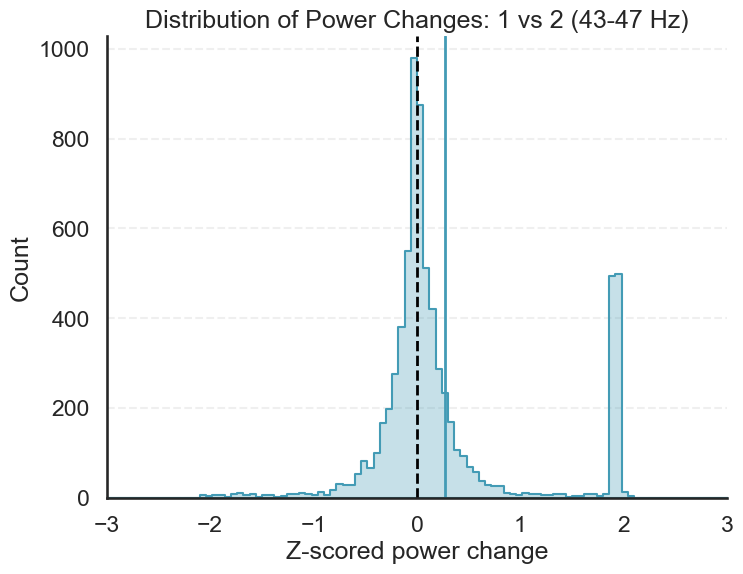

Total number of bins for 2 vs 3: 101
-0.13239460543932866 -0.03399285508923752


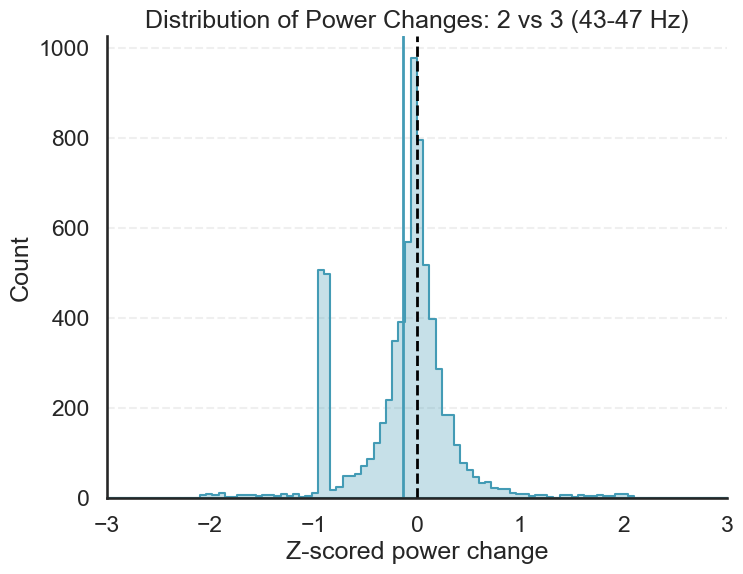

In [328]:
analyze_power_changes(
    sample_ppower_df, ['1', '2', '3'], band=(43,47), color=phase_palette[3], 
    bins= (-3,3,0.06), xlim=(-3,3)
 )

## Relative power

In [ ]:
def calculate_relative_power_full_array(power_array):
    """
    Calculate relative power per time bin, trial, and tetrode, expressed as a percentage 
    for each frequency bin. Each time bin's total power (across all frequency bins) 
    is normalized to 100%.

    Parameters:
    - power_array: np.ndarray
        4D array with shape (time_bins, trials, frequency_bins, tetrodes), representing PSD values.

    Returns:
    - relative_power_array: np.ndarray
        4D array with the same shape as `power_array` (time_bins, trials, frequency_bins, tetrodes),
        where each value represents the relative power in percentage for each frequency bin
        within each time bin, trial, and tetrode.
    """

    # Calculate the total power for each time bin, trial, and tetrode
    # Shape: (time_bins, trials, 1, tetrodes)
    total_power = np.sum(power_array, axis=2, keepdims=True)

    # Calculate relative power as (power in each frequency bin / total power) * 100
    relative_power_array = (power_array / total_power) * 100

    return relative_power_array


In [ ]:
# Remove outliers from absolute power
iti_abs_power_processed = remove_outliers_zscored(iti_power.copy(), z_threshold=2.5)
iti_rel_power = calculate_relative_power_full_array(iti_abs_power_processed)

In [ ]:
sample_abs_power_processed = remove_outliers_zscored(sample_power.copy(), z_threshold=2.5)
sample_rel_power = calculate_relative_power_full_array(sample_abs_power_processed)

In [ ]:
delay_abs_power_processed = remove_outliers_zscored(delay_power.copy(), z_threshold=2.5)
delay_rel_power = calculate_relative_power_full_array(delay_abs_power_processed)

In [ ]:
test_abs_power_processed = remove_outliers_zscored(test_power.copy(), z_threshold=2.5)
test_rel_power = calculate_relative_power_full_array(test_abs_power_processed)